# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
pip install scipy==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import os
import imageio
import matplotlib.pyplot as plt

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
import keras
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
from keras import optimizers

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
pythonpath=r"/content/drive/MyDrive/pgdm_aiml_projects/Gesture Recognition Project/Project_data//"

In [7]:
# train_doc = np.random.permutation(open('/content/drive/MyDrive/pgdm_aiml_projects/Gesture Recognition Project/Project_data/train.csv').readlines())
# val_doc = np.random.permutation(open('/content/drive/MyDrive/pgdm_aiml_projects/Gesture Recognition Project/Project_data/val.csv').readlines())
train_doc = np.random.permutation(open(pythonpath+r'train.csv').readlines())
val_doc = np.random.permutation(open(pythonpath+r'val.csv').readlines())
batch_size = 51

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    
                    # Cropped image of above dimension 
                    # (It will not change orginal image) 
                    
                    #image = image.crop((0, 0, 120, 120))
                    image = image.resize(100, 100)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if((len(source_path)%batch_size)//2==0):
            batch_size = 2
        else:
            batch_size = 1
        num_batches = len(source_path)%batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    
                    # Cropped image of above dimension 
                    # (It will not change orginal image) 
                    
                    #image = image.crop((0, 0, 120, 120))
                    image = image.resize(100, 100)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Sample image

In [46]:
sample_image = os.listdir(pythonpath+r'train'+'/'+ np.random.permutation(train_doc)[0 + (0)].split(';')[0])

In [47]:
print(sample_image)

['WIN_20180926_17_15_10_Pro_00005.png', 'WIN_20180926_17_15_10_Pro_00009.png', 'WIN_20180926_17_15_10_Pro_00017.png', 'WIN_20180926_17_15_10_Pro_00013.png', 'WIN_20180926_17_15_10_Pro_00007.png', 'WIN_20180926_17_15_10_Pro_00011.png', 'WIN_20180926_17_15_10_Pro_00015.png', 'WIN_20180926_17_15_10_Pro_00031.png', 'WIN_20180926_17_15_10_Pro_00061.png', 'WIN_20180926_17_15_10_Pro_00041.png', 'WIN_20180926_17_15_10_Pro_00053.png', 'WIN_20180926_17_15_10_Pro_00047.png', 'WIN_20180926_17_15_10_Pro_00019.png', 'WIN_20180926_17_15_10_Pro_00023.png', 'WIN_20180926_17_15_10_Pro_00039.png', 'WIN_20180926_17_15_10_Pro_00063.png', 'WIN_20180926_17_15_10_Pro_00055.png', 'WIN_20180926_17_15_10_Pro_00027.png', 'WIN_20180926_17_15_10_Pro_00021.png', 'WIN_20180926_17_15_10_Pro_00035.png', 'WIN_20180926_17_15_10_Pro_00049.png', 'WIN_20180926_17_15_10_Pro_00025.png', 'WIN_20180926_17_15_10_Pro_00057.png', 'WIN_20180926_17_15_10_Pro_00059.png', 'WIN_20180926_17_15_10_Pro_00051.png', 'WIN_20180926_17_15_10_P

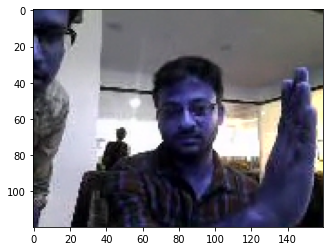

In [53]:
sample_im_path = pythonpath+r'train'+'/'+ train_doc[0].split(';')[0]
sample = cv2.imread(sample_im_path+'/'+os.listdir(sample_im_path)[0])
plt.imshow(sample)

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = pythonpath+r'train'
val_path = pythonpath+r'val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [23]:
#write your model here
Input_shape = (18, 100, 100, 3)
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
K.set_value(model.optimizer.learning_rate, 0.001)
print (model.summary())
# optimiser = optimizers.Adam(lr=0.001)
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 100, 100, 32)  2624      
                                                                 
 activation_11 (Activation)  (None, 18, 100, 100, 32)  0         
                                                                 
 batch_normalization_8 (Batc  (None, 18, 100, 100, 32)  128      
 hNormalization)                                                 
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 98, 98, 32)    27680     
                                                                 
 activation_12 (Activation)  (None, 16, 98, 98, 32)    0         
                                                                 
 batch_normalization_9 (Batc  (None, 16, 98, 98, 32)   128       
 hNormalization)                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [25]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [26]:
model_name = 'gesture_recognition' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [27]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [28]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/MyDrive/pgdm_aiml_projects/Gesture Recognition Project/Project_data//train ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.6093 - categorical_accuracy: 0.3514Source path =  /content/drive/MyDrive/pgdm_aiml_projects/Gesture Recognition Project/Project_data//val ; batch size = 64

Epoch 1: saving model to gesture_recognition_2022-07-0918_12_18.015506/model-00001-1.60926-0.35135-1.60957-0.13846.h5
11/11 [==============================] - 231s 22s/step - loss: 1.6093 - categorical_accuracy: 0.3514 - val_loss: 1.6096 - val_categorical_accuracy: 0.1385 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.6090 - categorical_accuracy: 0.2727
Epoch 2: saving model to gesture_recognition_2022-07-0918_12_18.015506/model-00002-1.60896-0.27273-1.61501-0.00000.h5
11/11 [==============================] - 38s 4s/step - loss: 1.6090 - categorical_accuracy: 0.2727 - val_loss: 1.6150 - val_categorical_accu

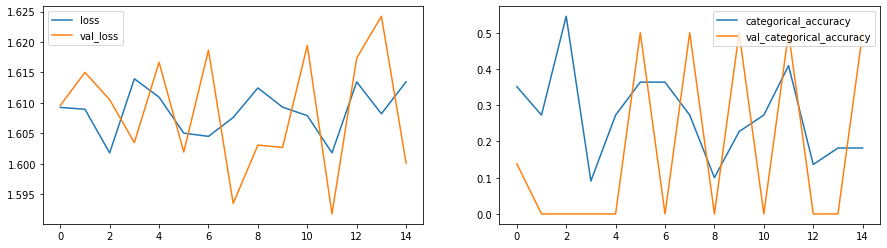

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history.history['loss'])   
axes[0].plot(history.history['val_loss'])
axes[0].legend(['loss','val_loss'])


axes[1].plot(history.history['categorical_accuracy'])   
axes[1].plot(history.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])


As we can see, there's a lot more scope of improvement in the model, as this model is performing poorly.

## Model 2:- Model CONV2D + LSTM

```
# This is formatted as code
```



In [39]:
#write your model here
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional


Input_shape_1 = (18, 100, 100, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Flatten()))
 
model.add(Dropout(0.5))
model.add(LSTM(512, return_sequences=False, dropout=0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 50, 50, 32)   4736      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 48, 48, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 24, 24, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 24, 24, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 24, 24, 64)  

In [40]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
K.set_value(model.optimizer.learning_rate, 0.001)
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 50, 50, 32)   4736      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 48, 48, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 24, 24, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 24, 24, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 24, 24, 64)  

In [41]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [42]:
model_name = 'Gesture_recog_model2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

In [43]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [44]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/MyDrive/pgdm_aiml_projects/Gesture Recognition Project/Project_data//train ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.6121 - categorical_accuracy: 0.2297Source path =  /content/drive/MyDrive/pgdm_aiml_projects/Gesture Recognition Project/Project_data//val ; batch size = 64

Epoch 1: saving model to Gesture_recog_model2_2022-07-0918_12_18.015506/model-00001-1.61214-0.22973-1.61618-0.20000.h5
11/11 [==============================] - 69s 6s/step - loss: 1.6121 - categorical_accuracy: 0.2297 - val_loss: 1.6162 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.6207 - categorical_accuracy: 0.0909
Epoch 2: saving model to Gesture_recog_model2_2022-07-0918_12_18.015506/model-00002-1.62070-0.09091-1.60467-0.00000.h5
11/11 [==============================] - 21s 2s/step - loss: 1.6207 - categorical_accuracy: 0.0909 - val_loss: 1.6047 - val_categorical_accu

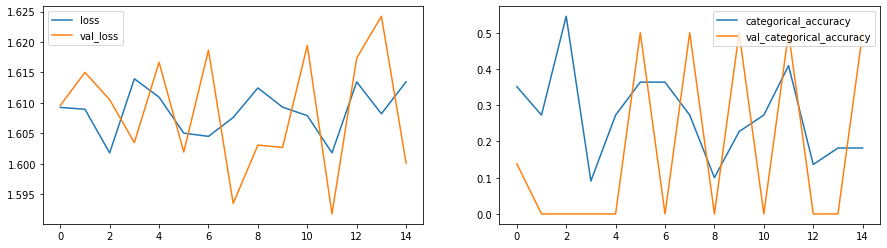

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history.history['loss'])   
axes[0].plot(history.history['val_loss'])
axes[0].legend(['loss','val_loss'])


axes[1].plot(history.history['categorical_accuracy'])   
axes[1].plot(history.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])


## Model 3

In [89]:
batch_size = 64 

In [98]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,3) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    
                    # Cropped image of above dimension 
                    # (It will not change orginal image) 
                    
                    #image = image.crop((0, 0, 120, 120))
                    image = image.resize(100, 100)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if((len(source_path)%batch_size)//2==0):
            batch_size = 2
        else:
            batch_size = 1
        num_batches = len(source_path)%batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    
                    # Cropped image of above dimension 
                    # (It will not change orginal image) 
                    
                    #image = image.crop((0, 0, 120, 120))
                    image = image.resize(100, 100)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [99]:
curr_dt_time = datetime.datetime.now()
train_path = pythonpath+r'train'
val_path = pythonpath+r'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)
num_classes = 5

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [101]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

model = Sequential()

Input_shape_1 = (18, 100, 100, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (2, 2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))

In [102]:
# compile it
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])

# summary of model
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_84 (TimeDi  (None, 18, 50, 50, 32)   4736      
 stributed)                                                      
                                                                 
 batch_normalization_48 (Bat  (None, 18, 50, 50, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_85 (TimeDi  (None, 18, 49, 49, 16)   2064      
 stributed)                                                      
                                                                 
 activation_71 (Activation)  (None, 18, 49, 49, 16)    0         
                                                                 
 batch_normalization_49 (Bat  (None, 18, 49, 49, 16)   64        
 chNormalization)                                    

In [103]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [104]:
# model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
model_name = 'gesture_rec_model3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#LR = # write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
callbacks_list = [checkpoint]


In [105]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [108]:
history3=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


11/11 [==============================] - ETA: 0s - loss: 2.4212 - categorical_accuracy: 0.1364
Epoch 1: saving model to gesture_rec_model3_2022-07-0920_11_26.944585/model-00001-2.42125-0.13636-2.41521-0.50000.h5
11/11 [==============================] - 5s 486ms/step - loss: 2.4212 - categorical_accuracy: 0.1364 - val_loss: 2.4152 - val_categorical_accuracy: 0.5000
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 2.4044 - categorical_accuracy: 0.3182
Epoch 2: saving model to gesture_rec_model3_2022-07-0920_11_26.944585/model-00002-2.40436-0.31818-2.39607-0.25000.h5
11/11 [==============================] - 2s 177ms/step - loss: 2.4044 - categorical_accuracy: 0.3182 - val_loss: 2.3961 - val_categorical_accuracy: 0.2500
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 2.3919 - categorical_accuracy: 0.2273
Epoch 3: saving model to gesture_rec_model3_2022-07-0920_11_26.944585/model-00003-2.39186-0.22727-2.48239-0.00000.h5
11/11 [=========================

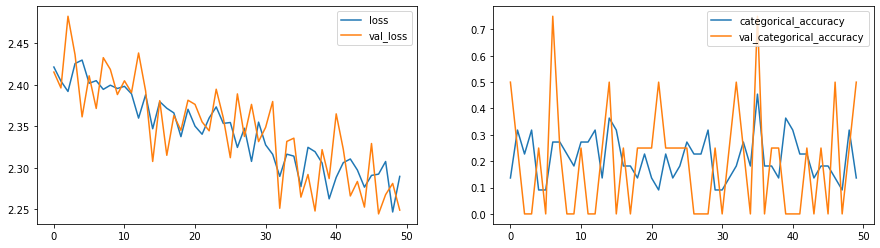

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history3.history['loss'])   
axes[0].plot(history3.history['val_loss'])
axes[0].legend(['loss','val_loss'])


axes[1].plot(history3.history['categorical_accuracy'])   
axes[1].plot(history3.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])